In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

In [3]:
df = pd.read_csv("Predictive Maintenance_data.csv")
df.head()

,timestamp,vibration,temperature,pressure,rotational_speed,failure
0,2023-01-01 00:00:00,0.549671,67.881202,27.964516,1485.657678,0
1,2023-01-01 01:00:00,0.486174,67.732929,29.083502,1496.734410,0
2,2023-01-01 02:00:00,0.564769,61.021784,28.207857,1506.429488,0
3,2023-01-01 03:00:00,0.652303,68.349549,30.331254,1594.686146,0
4,2023-01-01 04:00:00,0.476585,73.664145,33.591536,1425.278269,0


In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')

In [5]:
window = 5

df['vibration_mean'] = df['vibration'].rolling(window).mean()
df['vibration_std'] = df['vibration'].rolling(window).std()

df['temp_mean'] = df['temperature'].rolling(window).mean()
df['temp_std'] = df['temperature'].rolling(window).std()

df['pressure_mean'] = df['pressure'].rolling(window).mean()

df.dropna(inplace=True)

In [6]:
X = df.drop(['timestamp', 'failure'], axis=1)
y = df['failure']

In [7]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.2,
    random_state=42
)

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# RANDOM FOREST MODEL

In [10]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42
)

rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [11]:
rf_pred = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))

Random Forest Accuracy: 0.9731154454401687
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       945
           1       0.98      0.97      0.97       952

    accuracy                           0.97      1897
   macro avg       0.97      0.97      0.97      1897
weighted avg       0.97      0.97      0.97      1897



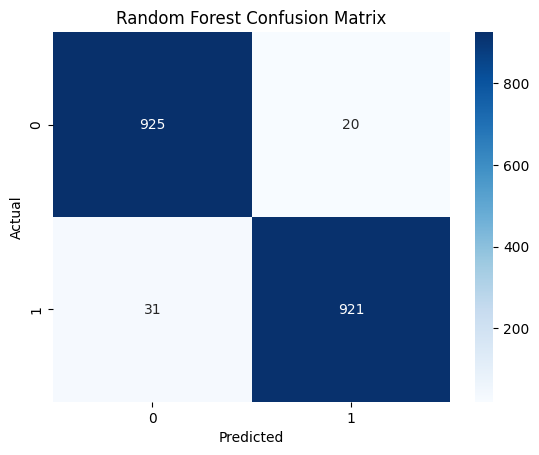

In [12]:
cm = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# XGBOOST MODEL 

In [13]:
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [14]:
xgb_pred = xgb.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred))

XGBoost Accuracy: 0.985239852398524
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       945
           1       0.98      0.99      0.99       952

    accuracy                           0.99      1897
   macro avg       0.99      0.99      0.99      1897
weighted avg       0.99      0.99      0.99      1897



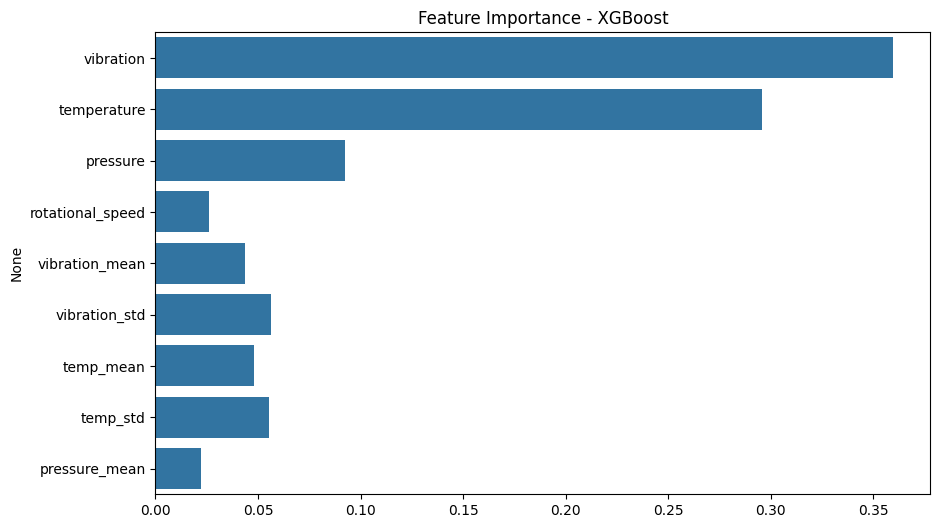

In [15]:
importances = xgb.feature_importances_
features = X.columns

plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance - XGBoost")
plt.show()